In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import os
import json
import uuid

import rdkit
print(rdkit.__version__)
import lwreg
from lwreg import standardization_lib
from lwreg import utils
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'




2023.03.3


In [2]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
    WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835'
'''
# Execute the SQL query
cur.execute(sql_query)

# Fetch the results if needed
results = cur.fetchall()
print(f'{len(results)} results fetched')

# Print the column names
column_names = [desc[0] for desc in cur.description]
print(column_names)
confids = [r[0] for r in results]
molregnos = [r[1] for r in results]
mdfps = [json.loads(r[2]['mdfp']) for r in results]
vps = [r[3] for r in results]


3019 results fetched
['confid', 'molregno', 'mdfp', 'vp']


In [3]:
#disect the mdfps
example = {'2d_counts': [6, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'water_intra_crf': [8.447469879840682, 0.07754269775241597, 8.448101852311458], 'water_intra_lj': [14.698494638650427, 0.35388130931658185, 14.62080608686442], 'water_total_crf': [-20.59946506906263, 8.513642293598433, -18.724968586184893], 'water_total_lj': [-20.978276995376827, 4.06594223290863, -22.954899317973993], 'water_intra_ene': [23.14596451849111, 0.3528157869181612, 23.10431903412804], 'water_total_ene': [-41.57774206443945, 6.698043493291234, -39.76306852550783], 'water_rgyr': [1.4897907974950872, 0.0031876909007386768, 1.4891081418027634], 'water_sasa': [2.433884, 0.007920546, 2.4333215]}
mdfp_keys = list(example.keys())
mdfp_keys_full =[]
features_2d = ['NumHeavyAtoms','NumRotatableBonds','NumN','NumO','NumF','NumP','NumS','NumCl','NumBr','NumI']
for key in mdfp_keys:
    if key != '2d_counts':
        for i in ['mean', 'std', 'median']:
            mdfp_keys_full.append(f'{key}_{i}')
    else:
        mdfp_keys_full.extend(features_2d)
print(mdfp_keys_full,len(mdfp_keys_full))
#now make a df from data that we have
df = pd.DataFrame(results, columns=column_names)
#add the mdfp keys
for i,key in enumerate(mdfp_keys_full):
    df[key] = [mdfps[j][i] for j in range(len(mdfps))]

['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median'] 34


In [4]:
#X_train: df all columns except vp
X_train = df.drop(columns=['vp','confid','molregno','mdfp'])
#y_train: df vp
y_train = df['vp']
from interpret.glassbox import ExplainableBoostingRegressor

ebm = ExplainableBoostingRegressor()
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor()

In [5]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

/localhome/cschiebroek/.conda/envs/interpret_ML/lib/python3.11/site-packages/interpret/visual/_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7001/139651814747664/ -->

In [6]:
#But for now, lets move on to the ML part. Lets start with ShuZen's code, but attempting to get it a bit more clean
#Lets start with doing 5 fold cross validation, getting the plot and getting MAE, RMSE and R2
from sklearn.model_selection import KFold
import numpy as np
import tqdm
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from functools import reduce
from scipy.stats import linregress


def getStatValues(x,y):
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    this_rmse = mean_squared_error(np.array(x), np.array(y), squared=False)
    this_mue = mean_absolute_error(np.array(x), np.array(y))
    return slope, intercept, r_value**2, this_rmse, this_mue

kf = KFold(5)
X = mdfps
y = vps
num_boost_round = 999
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
output = ([],[])
rmse_arr , mae_arr = [] , []
feature_importance = []

for train, test in tqdm.tqdm(kf.split(X)):
    train_x = np.array(X)[train]
    train_y = np.array(y)[train]
    test_x = np.array(X)[test]
    test_y = np.array(y)[test]
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)

    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )
    pp = model.predict(dtest)

    output[0].append(test_y)
    output[1].append(pp)
    print(model.get_fscore())
    print(model.get_score(importance_type='gain'))
    print(model.get_score(importance_type='weight'))
    feature_importance.append(model.get_score(importance_type='gain'))

real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(prediction, real)
print('RMSE: ', this_rmse)
print('MAE: ', this_mae)
print('R2: ', r2)



0it [00:00, ?it/s]

3it [00:00,  9.40it/s]

{'f0': 55.0, 'f1': 34.0, 'f2': 41.0, 'f3': 37.0, 'f4': 21.0, 'f5': 3.0, 'f6': 12.0, 'f7': 10.0, 'f8': 9.0, 'f9': 3.0, 'f10': 57.0, 'f11': 70.0, 'f12': 6.0, 'f13': 63.0, 'f14': 60.0, 'f15': 19.0, 'f16': 34.0, 'f17': 99.0, 'f18': 3.0, 'f19': 62.0, 'f20': 69.0, 'f21': 21.0, 'f22': 23.0, 'f23': 56.0, 'f24': 6.0, 'f25': 19.0, 'f26': 60.0, 'f27': 3.0, 'f28': 60.0, 'f29': 64.0, 'f30': 28.0, 'f31': 52.0, 'f32': 58.0, 'f33': 16.0}
{'f0': 660.3966064453125, 'f1': 20.343460083007812, 'f2': 25.5051212310791, 'f3': 12.920592308044434, 'f4': 34.629764556884766, 'f5': 16.417339324951172, 'f6': 11.29865550994873, 'f7': 8.349943161010742, 'f8': 9.769386291503906, 'f9': 4.433901309967041, 'f10': 4.988000392913818, 'f11': 5.775772571563721, 'f12': 2.9686996936798096, 'f13': 16.493471145629883, 'f14': 8.896038055419922, 'f15': 6.278628349304199, 'f16': 4.696926593780518, 'f17': 57.23347854614258, 'f18': 1.312474250793457, 'f19': 9.010717391967773, 'f20': 32.95259475708008, 'f21': 5.531726360321045, 'f22':

5it [00:00, 10.99it/s]

{'f0': 50.0, 'f1': 20.0, 'f2': 33.0, 'f3': 27.0, 'f4': 19.0, 'f5': 2.0, 'f6': 11.0, 'f7': 10.0, 'f8': 10.0, 'f9': 3.0, 'f10': 36.0, 'f11': 57.0, 'f12': 6.0, 'f13': 42.0, 'f14': 44.0, 'f15': 11.0, 'f16': 26.0, 'f17': 54.0, 'f18': 10.0, 'f19': 46.0, 'f20': 36.0, 'f21': 16.0, 'f22': 22.0, 'f23': 26.0, 'f24': 5.0, 'f25': 16.0, 'f26': 47.0, 'f27': 2.0, 'f28': 54.0, 'f29': 42.0, 'f30': 19.0, 'f31': 27.0, 'f32': 52.0, 'f33': 5.0}
{'f0': 754.4302368164062, 'f1': 31.383275985717773, 'f2': 25.27412223815918, 'f3': 20.055809020996094, 'f4': 36.288108825683594, 'f5': 36.633880615234375, 'f6': 12.920716285705566, 'f7': 5.840734481811523, 'f8': 13.74809455871582, 'f9': 4.453251361846924, 'f10': 6.917246341705322, 'f11': 10.0819091796875, 'f12': 6.205437183380127, 'f13': 18.909061431884766, 'f14': 14.19275188446045, 'f15': 18.584306716918945, 'f16': 5.389012336730957, 'f17': 79.56636047363281, 'f18': 5.561247825622559, 'f19': 8.904175758361816, 'f20': 67.35921478271484, 'f21': 17.08199691772461, 'f22

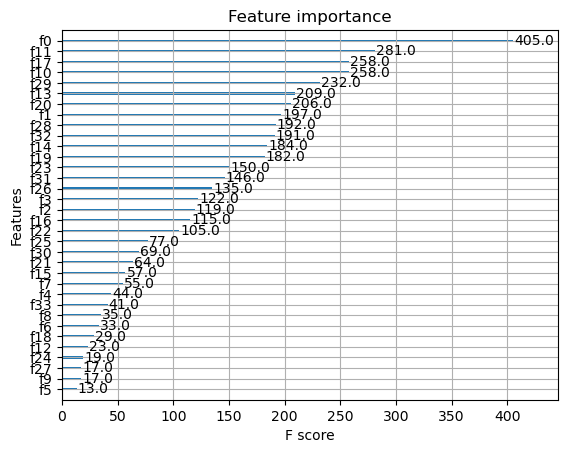

In [7]:
import xgboost as xgb
import matplotlib.pyplot as plt
X_train = mdfps
y_train = vps
# Train your XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Plot feature importances
xgb.plot_importance(model, importance_type='weight')  # You can use 'weight', 'gain', or 'cover'
plt.show()


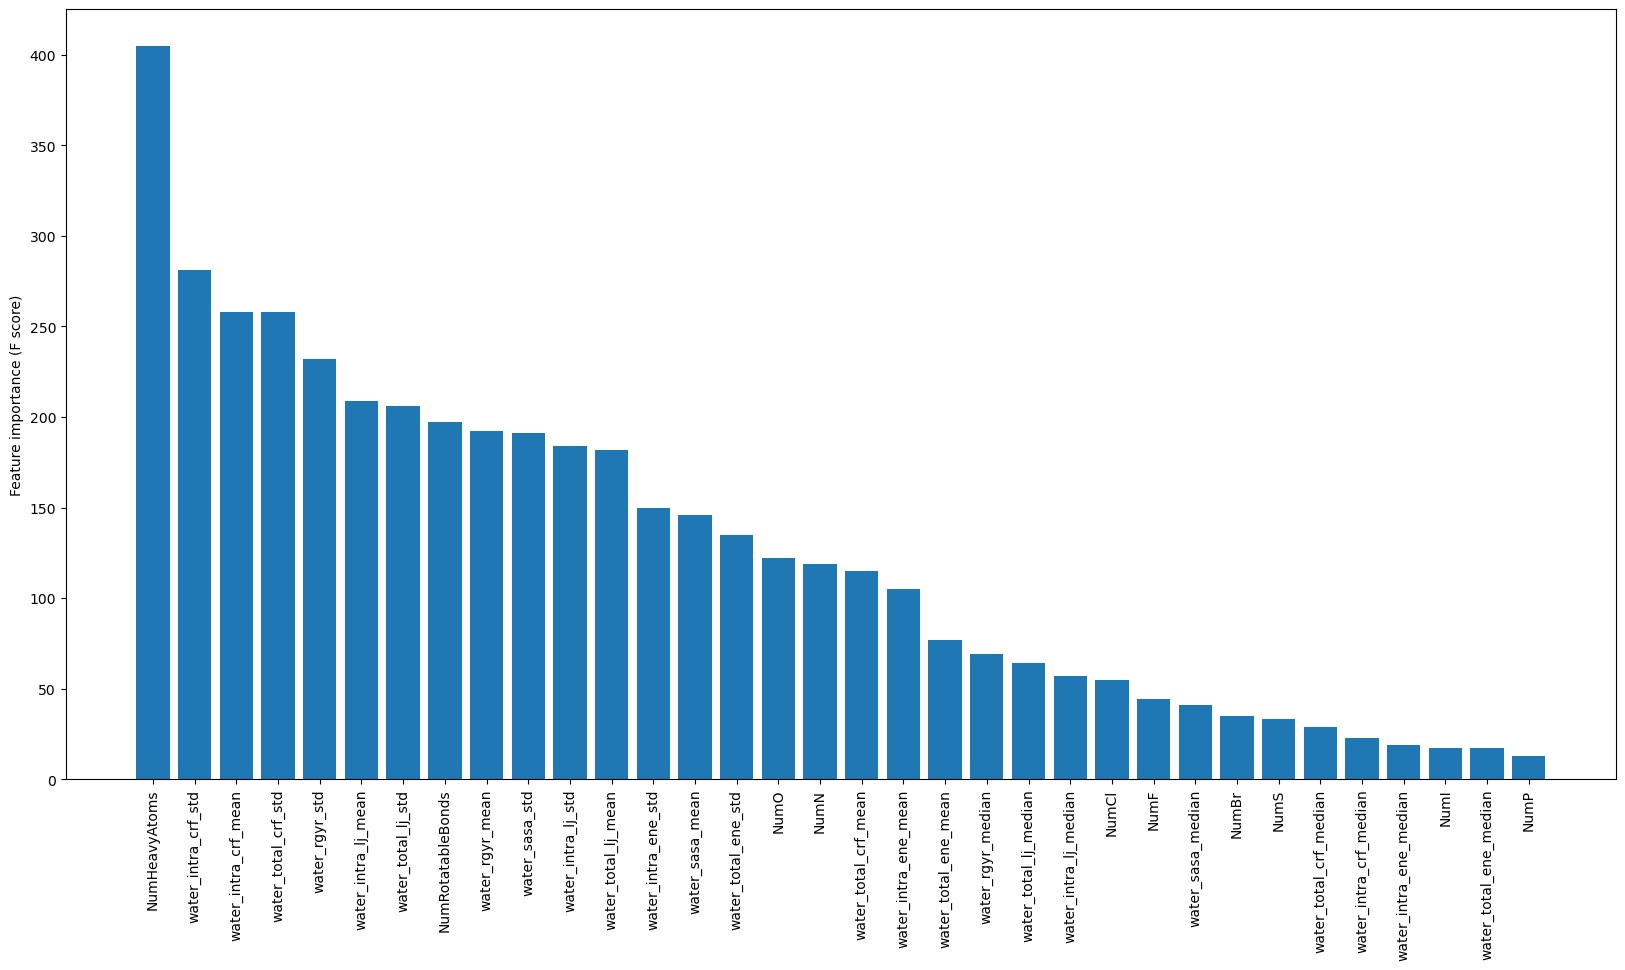

In [8]:
#also get the numbers
feature_importance_dict = model.get_booster().get_score(importance_type='weight')
#change the keys to the actual names
feature_importance_dict = {mdfp_keys_full[int(key[1:])]:value for key,value in feature_importance_dict.items()}
#sort
feature_importance_dict = {k: v for k, v in sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)}
#plot this
plt.figure(figsize=(20,10))
plt.bar(feature_importance_dict.keys(), feature_importance_dict.values())
plt.xticks(rotation=90)
plt.ylabel('Feature importance (F score)')
plt.show()

In [12]:
df_mdfps_features = pd.read_csv('mdfp_and_rdkit_features_all_mols.csv')
#X_train: df all columns except vp
X_train = df_mdfps_features.drop(columns=['vp','confid','molregno','mdfp'])
#y_train: df vp
y_train = df_mdfps_features['vp']
from interpret.glassbox import ExplainableBoostingRegressor

ebm = ExplainableBoostingRegressor()
ebm.fit(X_train, y_train)

/localhome/cschiebroek/.conda/envs/interpret_ML/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:669: UserWarning:

Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]



ExplainableBoostingRegressor()

In [13]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

/localhome/cschiebroek/.conda/envs/interpret_ML/lib/python3.11/site-packages/interpret/visual/_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7001/139647151232208/ -->

In [69]:
EBM_features = ['water_rgyr_mean','MinAbsEStateIndex','water_rgyr_median','water_total_crf_std','water_total_ene_std','water_total_lj_std','VSA_EState8','NumHDonors','SMR_VSA10','Chi1v','AvgIpc','TPSA','MolWt','VSA_EState3','NumHeavyAtoms']
#train model with these features
print(len(EBM_features))
#check how many of these are MDFP features and how many are rdkit features
mdfp_features = [feature for feature in EBM_features if feature in mdfp_keys_full]
rdkit_features = [feature for feature in EBM_features if feature not in mdfp_keys_full]
print(f'{len(mdfp_features)} MDFP features and {len(rdkit_features)} rdkit features')

15
6 MDFP features and 9 rdkit features


In [70]:
#1. Most import features (many)

#X will be the mdfp features + the mol features
X = df_mdfps_features[EBM_features]
y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
X = X.dropna()
y = y[X.index]
#now do the cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

params = params
output = ([], [])

for train, test in tqdm.tqdm(kf.split(X)):
        
        train_x = np.array(X)[train]
        train_y = np.array(y)[train]

        test_x = np.array(X)[test]
        test_y = np.array(y)[test]
        
        dtrain = xgb.DMatrix(train_x, label=train_y)
        dtest = xgb.DMatrix(test_x, label=test_y)
        model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

        )
        # Evaluate the model
        predictions = model.predict(dtest)

        output[0].append(test_y)
        output[1].append(predictions)

5it [00:00, 22.33it/s]


In [71]:
from functools import reduce
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(prediction, real)
print('RMSE: ', this_rmse)
print('MAE: ', this_mae)
print('R2: ', r2)

RMSE:  1.3675608964072006
MAE:  0.8404182146016715
R2:  0.8569282073240015


In [51]:
ebm_global.data().keys()
names = ebm_global.data()['names']
scores = ebm_global.data()['scores']
#make df with names and scores
df_ebm = pd.DataFrame({'names':names,'scores':scores})
#sort
df_ebm = df_ebm.sort_values(by='scores',ascending=False)
features_sorted = df_ebm['names'].tolist()

In [57]:
metric_dicts = []
for i in range(1,len(features_sorted)+1):
        print(f'Now doing {i} features')
        selected = features_sorted[:i]
        X = df_mdfps_features[selected]
        y = df_mdfps_features['vp']

        # remove rows with NaNs from X and y
        X = X.dropna()
        y = y[X.index]
        #now do the cross validation
        from sklearn.model_selection import KFold
        kf = KFold(n_splits=5)

        params = params
        output = ([], [])

        for train, test in tqdm.tqdm(kf.split(X)):
                
                train_x = np.array(X)[train]
                train_y = np.array(y)[train]

                test_x = np.array(X)[test]
                test_y = np.array(y)[test]
                
                dtrain = xgb.DMatrix(train_x, label=train_y)
                dtest = xgb.DMatrix(test_x, label=test_y)
                model = xgb.train(
                params,
                dtrain,
                num_boost_round=999,
                evals=[(dtest, "Test")],
                early_stopping_rounds=10,
                verbose_eval=False

                )
                # Evaluate the model
                predictions = model.predict(dtest)

                output[0].append(test_y)
                output[1].append(predictions)
        real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
        slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(prediction, real)
        metric_dict = {'RMSE':this_rmse,'MAE':this_mae,'R2':r2}
        metric_dicts.append(metric_dict)


Now doing 1 features


5it [00:00, 20.61it/s]


Now doing 2 features


5it [00:00, 29.94it/s]


Now doing 3 features


5it [00:00, 33.10it/s]


Now doing 4 features


5it [00:00, 29.87it/s]


Now doing 5 features


5it [00:00, 25.74it/s]


Now doing 6 features


5it [00:00, 23.83it/s]


Now doing 7 features


5it [00:00, 31.64it/s]


Now doing 8 features


5it [00:00, 26.14it/s]


Now doing 9 features


5it [00:00, 21.15it/s]


Now doing 10 features


5it [00:00, 26.65it/s]


Now doing 11 features


5it [00:00, 19.26it/s]


Now doing 12 features


5it [00:00, 18.32it/s]


Now doing 13 features


5it [00:00, 25.32it/s]


Now doing 14 features


5it [00:00, 21.00it/s]


Now doing 15 features


5it [00:00, 29.83it/s]


Now doing 16 features


5it [00:00, 16.27it/s]


Now doing 17 features


5it [00:00, 25.02it/s]


Now doing 18 features


5it [00:00, 19.53it/s]


Now doing 19 features


5it [00:00, 18.15it/s]


Now doing 20 features


5it [00:00, 16.78it/s]


Now doing 21 features


5it [00:00, 24.94it/s]


Now doing 22 features


5it [00:00, 15.01it/s]


Now doing 23 features


5it [00:00, 17.85it/s]


Now doing 24 features


5it [00:00, 10.20it/s]


Now doing 25 features


5it [00:00, 10.00it/s]


Now doing 26 features


5it [00:00, 13.96it/s]


Now doing 27 features


5it [00:00, 13.27it/s]


Now doing 28 features


5it [00:00, 17.43it/s]


Now doing 29 features


5it [00:00, 20.60it/s]


Now doing 30 features


5it [00:00, 16.01it/s]


Now doing 31 features


5it [00:00, 13.57it/s]


Now doing 32 features


5it [00:00, 15.49it/s]


Now doing 33 features


5it [00:00, 12.94it/s]


Now doing 34 features


5it [00:00, 13.21it/s]


Now doing 35 features


5it [00:00, 14.99it/s]


Now doing 36 features


5it [00:00, 13.86it/s]


Now doing 37 features


5it [00:00, 14.35it/s]


Now doing 38 features


5it [00:00, 13.10it/s]


Now doing 39 features


5it [00:00, 17.05it/s]


Now doing 40 features


5it [00:00, 13.14it/s]


Now doing 41 features


5it [00:00, 12.54it/s]


Now doing 42 features


5it [00:00, 13.13it/s]


Now doing 43 features


5it [00:00, 13.25it/s]


Now doing 44 features


5it [00:00, 10.15it/s]


Now doing 45 features


5it [00:00, 12.71it/s]


Now doing 46 features


5it [00:00, 15.28it/s]


Now doing 47 features


5it [00:00,  9.66it/s]


Now doing 48 features


0it [00:00, ?it/s]


XGBoostError: [12:26:51] /home/conda/feedstock_root/build_artifacts/xgboost-split_1693020740964/work/src/data/data.cc:1104: Check failed: valid: Input data contains `inf` or `nan`
Stack trace:
  [bt] (0) /localhome/cschiebroek/.conda/envs/interpret_ML/lib/libxgboost.so(+0xb6361) [0x7f0324cb6361]
  [bt] (1) /localhome/cschiebroek/.conda/envs/interpret_ML/lib/libxgboost.so(unsigned long xgboost::SparsePage::Push<xgboost::data::ArrayAdapterBatch>(xgboost::data::ArrayAdapterBatch const&, float, int)+0x5d3) [0x7f0324db6dd3]
  [bt] (2) /localhome/cschiebroek/.conda/envs/interpret_ML/lib/libxgboost.so(xgboost::data::SimpleDMatrix::SimpleDMatrix<xgboost::data::ArrayAdapter>(xgboost::data::ArrayAdapter*, float, int)+0x321) [0x7f0324e11d61]
  [bt] (3) /localhome/cschiebroek/.conda/envs/interpret_ML/lib/libxgboost.so(xgboost::DMatrix* xgboost::DMatrix::Create<xgboost::data::ArrayAdapter>(xgboost::data::ArrayAdapter*, float, int, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&)+0x37) [0x7f0324d96807]
  [bt] (4) /localhome/cschiebroek/.conda/envs/interpret_ML/lib/libxgboost.so(XGDMatrixCreateFromDense+0x314) [0x7f0324cde564]
  [bt] (5) /localhome/cschiebroek/.conda/envs/interpret_ML/lib/python3.11/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f034e46fa4a]
  [bt] (6) /localhome/cschiebroek/.conda/envs/interpret_ML/lib/python3.11/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f034e46efea]
  [bt] (7) /localhome/cschiebroek/.conda/envs/interpret_ML/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x12529) [0x7f034e487529]
  [bt] (8) /localhome/cschiebroek/.conda/envs/interpret_ML/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x8862) [0x7f034e47d862]



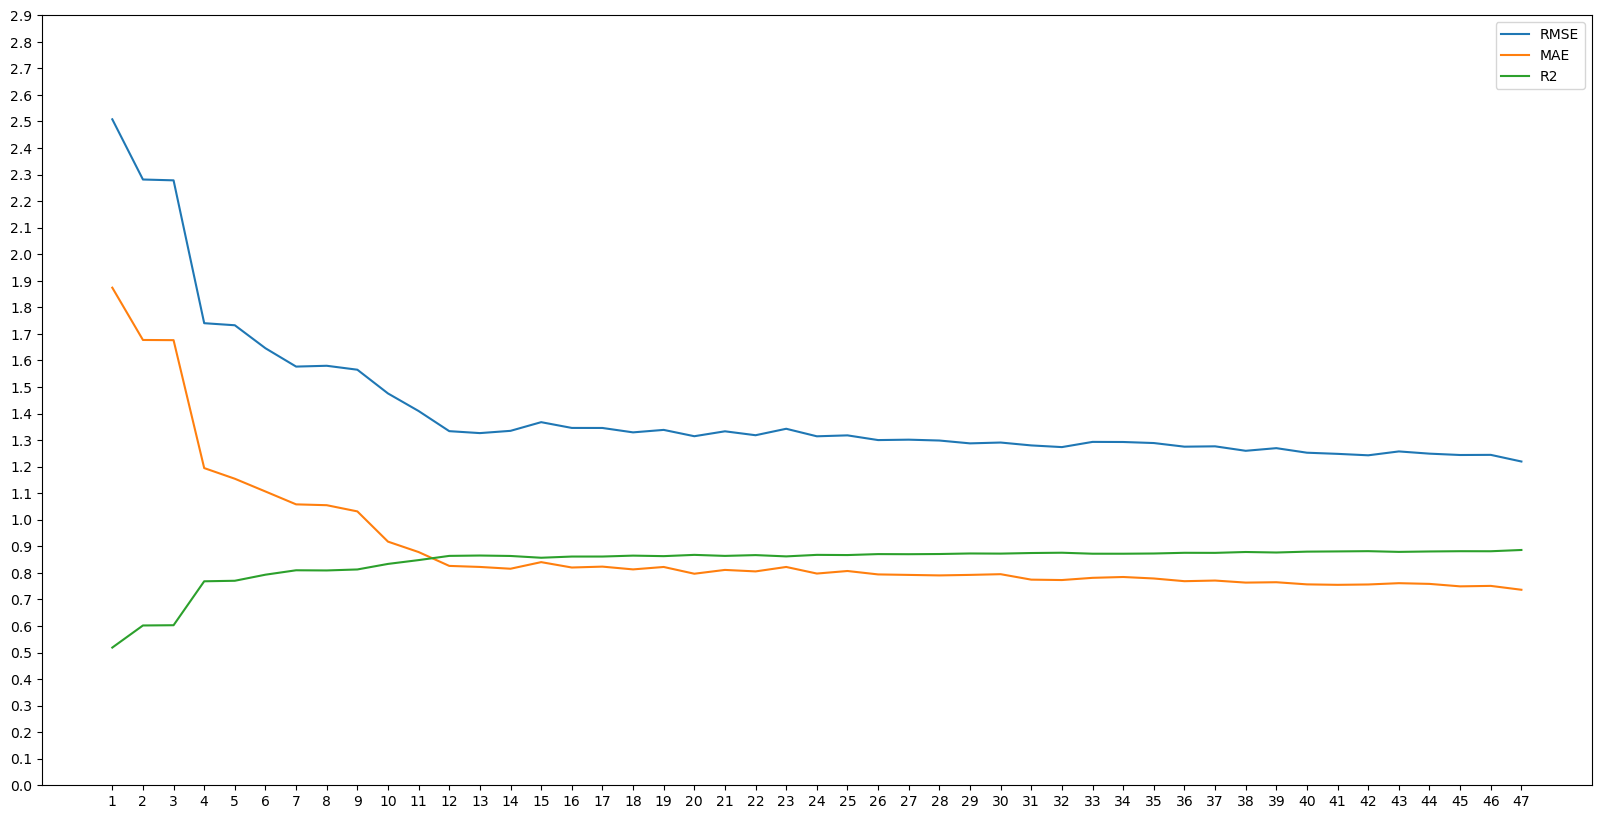

In [65]:
rmses, maes, r2s = [], [], []
for i in metric_dicts:
        rmses.append(i['RMSE'])
        maes.append(i['MAE'])
        r2s.append(i['R2'])
#plot
plt.figure(figsize=(20,10))
plt.plot(range(len(rmses)),rmses, label='RMSE')
plt.plot(range(len(maes)),maes, label='MAE')
plt.plot(range(len(r2s)),r2s, label='R2')
#more ticks on both axes
plt.xticks(range(len(rmses)),range(1,len(rmses)+1))
plt.yticks(np.arange(0, 3, 0.1))
plt.legend()
plt.show()

